## Part 1 implementing QAOA


### Question1 :
Write down in the cell below the Hamiltonian whose ground state is the solution to MaxCUT on an input graph $G=(V,E)$:

$$ H = \sum_{i,j\in E} \sigma_i \cdot \sigma_j $$
$$ E = \{(i,j) \in V^2\}$$

### Question 2:
Complete the implementation below of a simple, brute-force enumeration of all states computing the optimal solution to MaxCUT for the graph represented by 'edges'

In [1]:
import numpy as np

graph1 = [(0,1),(0,2),(1,3),(2,3)]
graph2 = [(0,1),(1,2),(0,3),(1,4),(2,5),(3,6),(4,7),(5,8),(3,4),(4,5),(6,7),(7,8)]
graph3 = [(0,1),(1,2),(0,3),(1,4),(2,5),(3,6),(4,7),(3,4),(4,5),(6,7)]
graph4 = [(0,1),(1,2),(2,3),(4,5),(5,6),(6,7),(0,4),(1,5),(2,6),(3,7)]
graph5 = [(0,1),(0,2),(1,3),(2,4),(3,5),(4,5),(1,4)]
graph6 = [(0,1),(0,2),(1,3),(2,4),(1,4)]


# choice of graph
edges = graph6

nqubits = max([max(list(v)) for v in edges])+1

#nqubits = 5
graph7 = [(i,(i+1)%nqubits) for i in range(nqubits)]+[(1,4)]


# COMPUTATION OF OPT.
best_value = len(edges)
best_b = 0
for x in range(2**nqubits):
    b = np.binary_repr(x, width=nqubits)
    b = [int(b[i]) for i in range(nqubits)]
    # TODO: Complete the computation below:
    val = 0
    for s_1,s_2 in edges:
        #on parcours toutes les arretes du graph et on resupère les sommets de l'arret
        
        #on ajoute +1 si les etats sont dans le meme sens
        val+=((b[s_1]==b[s_2])*2-1)
    
    # END TODO
    if val <= best_value:
        best_value = val
        best_b = b
print(best_value)
print(best_b)

-5
[1, 0, 0, 1, 1]


#### visualization of the graph

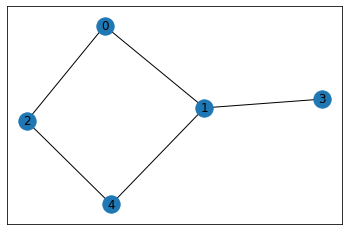

In [2]:
import networkx as nx
G = nx.Graph()
for i,j in edges:
    G.add_edge(i,j)
nx.draw_networkx(G)

In [3]:
from qat.lang.AQASM import Program, H, CNOT, RX, QRoutine, RZ, X, Z

In [4]:
def U_ZZ(theta):
    
    zz_r = QRoutine()
    zz_r.apply(CNOT, 0, 1)
    zz_r.apply(RZ(theta), 1) # difference of convention between implemented version and what we need.
    zz_r.apply(CNOT, 0, 1)

    return zz_r

### Question 3

In [5]:
def one_qaoa_layer(n_qubits, edges, theta, beta):

    layer = QRoutine()
    #TODO: implement one qaoa layer
    
    #on applique dabord RZ sur tous les qbits:
    for i in range(n_qubits):
        layer.apply(RX(2*theta), i)
    
    #ensuite on parcours les edges et on ajoute une rotation pour chacune:
    for i,j in edges:
        layer.apply(U_ZZ(beta),i,j)
    
    return layer

### Question 4

In [6]:
from qat.qpus import get_default_qpu

def evaluate_parameters(n_qubits, edges, parameters, n_layers):
    
    prog = Program()
    qubits = prog.qalloc(n_qubits)
    
    # TODO: implement initialization+parameterized circuit
    
    #on fais dabord l'initialisation des H
    for k in range(n_qubits):
        prog.apply(H,qubits[k])
        

    for i in range(len(parameters)//2):
        #on recupères les coefficients de la liste
        theta = parameters[2*i]
        beta = parameters[2*i+1]
        #on génère un layer de Qaoa avec ces paramètres
        layer = one_qaoa_layer(n_qubits, edges, theta, beta)
        prog.apply(layer,qubits)

        
    # END TODO
    circ = prog.to_circ()
    
    job = circ.to_job()
    qpu = get_default_qpu()
    
    result = qpu.submit(job)
    
    # BEGIN TODO
    obs = 0
    for sample in result:
        # this loop is over all 2**nqubits states.
        
        # sample.state.bitstring contains the qubit values (nqubits 0 or 1)
        b = sample.state.bitstring
        val = 0
        for s_1,s_2 in edges:
            #on parcours toutes les arretes du graph et on recupère les sommets de l'arret
            
            #on ajoute +1 si les etats sont dans le meme sens
            val+=((b[s_1]==b[s_2])*2-1)
        obs += val * sample.probability
    # END TODO
    return obs
    
        

In [7]:
import numpy as np
np.random.random(3)

array([0.04227615, 0.25989992, 0.38029406])

In [8]:
from scipy.optimize import minimize


### Random initialisation

### Question 5: 
réponse à la question:

8 layers suffisent pour atteindre la valeur optimal

In [9]:
import matplotlib.pylab as plt


for nlayers in range(8,11,1):
    num_params = 2*nlayers

    back_trace = []
    def print_avg(xk):
        eva = evaluate_parameters(nqubits, edges, xk,nlayers)
        back_trace.append(eva)
        print(eva, end=' ')

    opt_res = minimize(lambda x : evaluate_parameters(nqubits, edges, x, nlayers), 
                       np.random.random(num_params),
                       callback=print_avg,)
    plt.plot(back_trace,label=str(nlayers))
# there exists a classical polynomial algorithm returning solutions within a factor of 0.878 of the optimal
# we must at least beat that. https://fr.wikipedia.org/wiki/Coupe_maximum
plt.axhline(0.878*best_value, color='b', label="classical apx ratio")
plt.axhline(best_value,color='r',label='optimal value')
plt.legend()

0.02437096775402324 -1.5767632057124528 -1.911056825964732 -2.4871565858781417 -2.7352357981396844 -3.0048297672234106 -3.358027414362428 -3.5372778801376605 -3.8794412543686057 -4.232213660899821 -4.512016519138375 -4.669708354745196 -4.719182363532159 -4.771013637921 -4.790912396223076 -4.817339855080903 -4.852395012915876 -4.887393306932105 -4.9144513331822735 -4.931135115317771 -4.939932895218181 -4.946396462090144 -4.949156745496893 -4.951932297672084 -4.95363588694471 -4.954243644489782 -4.9551519485674955 -4.955996082604962 -4.956263380316505 -4.95637173089897 -4.956450851654574 -4.9565822816140725 -4.956788524551375 -4.957063089029112 -4.957320207008126 -4.9575073031916865 -4.957554717175497 -4.957571287317735 -4.957592998232257 -4.957628787526398 -4.957689158217265 -4.957794602820499 -4.957979561271465 -4.9582623783377775 -4.958635553122434 -4.959309080286068 -4.96020260365455 -4.96055657095212 -4.9611206611002885 -4.961548332213367 -4.961772519352106 -4.96209393122644 

KeyboardInterrupt: 

### Question 6: smart initialization

-0.147165261318996 -0.8363317305665335 -1.4875862493049885 -1.6318710798129994 -1.8072102462401787 -1.9520440542659339 -2.1964695071242155 -3.1152262104574677 -3.210671736646658 -3.388130745085718 -3.695899912019496 -3.940155163808684 -3.9639231779063087 -3.9780148459532896 -3.9782621643347786 -3.978268976594535 -3.978269028501082 -3.978269029651988 -0.79661394458565 -2.512301596091349 -2.8076234816507717 -3.291925111419918 -3.568295146808672 -3.740347669553069 -3.9855456662655424 -4.059534121924454 -4.070163187114732 -4.0852021488493975 -4.101868457353865 -4.109561235591398 -4.121477716602581 -4.139054699573876 -4.155560464568475 -4.165618364932582 -4.168246579228236 -4.173024116009213 -4.181305750798787 -4.194613623014073 -4.217980369701332 -4.259977022945687 -4.277374198301497 -4.296578674717458 -4.303645737753346 -4.311034943964081 -4.317441962545212 -4.326305357119447 -4.331538089367671 -4.333185371574301 -4.3334238554946305 -4.333456627009798 -4.333459657515265 -4.333459882090737

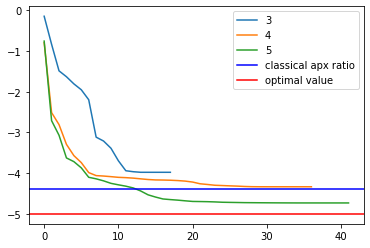

In [11]:
T = 1.

for nlayers in range(3,6,1):
    num_params = 2*nlayers

    back_trace = []
    def print_avg(xk):
        eva = evaluate_parameters(nqubits, edges, xk,nlayers)
        back_trace.append(eva)
        print(eva, end=' ')

    # TODO implement parameter init
    parameters_init = []
    
    for k in range(nlayers):
        theta = (1 - k/nlayers)*T/nlayers
        beta = k/nlayers*T/nlayers
        parameters_init.append(theta)
        parameters_init.append(beta)
    
    # END TODO        
    opt_res = minimize(lambda x : evaluate_parameters(nqubits, edges, x, nlayers), 
                       parameters_init, 
                       callback=print_avg,)
    plt.plot(back_trace,label=str(nlayers))
plt.axhline(0.878*best_value, color='b', label="classical apx ratio")
plt.axhline(best_value,color='r',label='optimal value')
plt.legend()